In [27]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import FreqDist
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
import random

random.seed(42)

# 1. data loading section

In [28]:
nums = 5000

def load_data(data_dir):
    global nums
    with open(data_dir, "r", encoding='utf-8') as fp:
        data = [line.strip().split("\t") for line in fp.readlines() if len(line.strip().split("\t"))==1]
    data = pd.DataFrame(data[:nums], columns=None)
    return data
    
texts_dir = "./Data/texts.txt"
summaries_dir = "./Data/summaries.txt"

texts = load_data(texts_dir)
summaries = load_data(summaries_dir)

In [29]:
# To ensure that our data is not too long, we choose a source text string of 6000 characters or less as our data set, 
# and the number of characters must be greater than 30
str_indexes = []
for i in range(len(texts)):
    if type(texts[0][i]) == type("str") and len(texts[0][i])<6000 and len(texts[0][i])>30:
        str_indexes.append(i)
texts = [texts[0][i] for i in str_indexes]
summaries = [summaries[0][i] for i in str_indexes]

In [30]:
# Finally we select 1457 data as our training set
lg = len(texts)
lg

1457

In [31]:
tlg = [len(i.split()) for i in texts]
slg = [len(i.split()) for i in summaries]

In [32]:
texts[1]

'PARIS (AP) — The Pompidou Centre in Paris hopes to display a long-vanished Picasso painting in May, now that it has been recovered by U.S. customs authorities. NEWLINE_CHAR NEWLINE_CHAR This undated photo provided by the United States Department of Justice, shows a cubist painting entitled “The Hairdresser” by Pablo Picasso. Authorities say the painting worth millions of dollars was... (Associated Press) NEWLINE_CHAR NEWLINE_CHAR The 1911 cubist painting "The Hairdresser," worth millions of dollars, was reported missing from a Pompidou storeroom in 2001. It was smuggled into the U.S. in December from Belgium. NEWLINE_CHAR NEWLINE_CHAR Pompidou director Alain Seban said the discovery comes as a "true comfort" at a time when the cultural world is reeling from an Islamic State video showing the destruction of statues in Iraq. NEWLINE_CHAR NEWLINE_CHAR Seban said in a statement Friday that he hopes the work can be exhibited again publicly in May. NEWLINE_CHAR NEWLINE_CHAR U.S. and French 

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
from scipy.stats import norm
from scipy.stats import laplace

In [36]:
CC = pd.read_csv("./Data/Clustered_predict_summaries.csv", low_memory=False)
T5 = pd.read_csv("./Data/T5_predict_summaries.csv", low_memory=False)

In [43]:
C = [len(i.split()) for i in list(CC["Clustered_predict"])]
T = [len(i.split()) for i in list(T5["T5_predict"])]

D:\Anaconda3\envs\hp\Lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


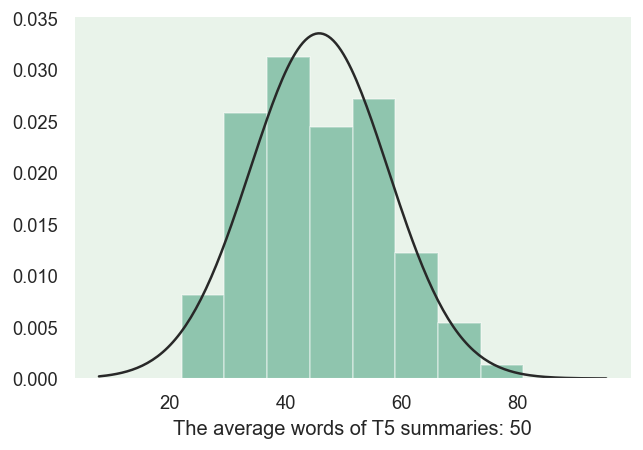

In [49]:
sns.set_palette("hls")
#sns.set_style("whitegrid")
plt.figure(dpi=120)
sns.set(style='dark')
sns.set_style("dark", {"axes.facecolor": "#e9f3ea"})
g = sns.distplot(T,
                 hist=True,
                 kde=False,  # 开启核密度曲线kernel density estimate (KDE)
                 kde_kws={'linestyle': '--', 'linewidth': '1', 'color': '#c72e29',
                          # 设置外框线属性
                          },
                 fit=norm,
                 color='#098154',
                 axlabel='The average words of T5 summaries: 50',  # 设置x轴标题

                 )

plt.show()

D:\Anaconda3\envs\hp\Lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


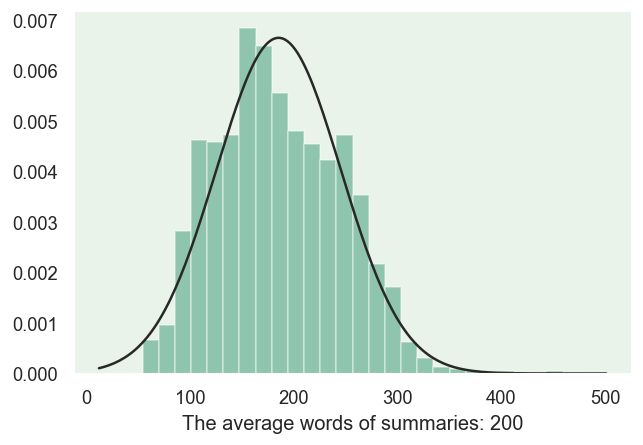

In [45]:
sns.set_palette("hls")
#sns.set_style("whitegrid")
plt.figure(dpi=120)
sns.set(style='dark')
sns.set_style("dark", {"axes.facecolor": "#e9f3ea"})
g = sns.distplot(slg,
                 hist=True,
                 kde=False,  # 开启核密度曲线kernel density estimate (KDE)
                 kde_kws={'linestyle': '--', 'linewidth': '1', 'color': '#c72e29',
                          # 设置外框线属性
                          },
                 fit=norm,
                 color='#098154',
                 axlabel='The average words of summaries: 200',  # 设置x轴标题

                 )

plt.show()

In [5]:
# Slice and dice the dataset into a training set and a test set
split = 0.25
def split_data(texts, summaries):
    global split, lg
    # Randomly get 2000*0.25 indexes within 2000 using the random module
    test_index = random.sample(range(lg),int(lg*split))

    train_texts = [texts[i] for i in range(lg) if i not in test_index]
    test_texts = [texts[i] for i in range(lg) if i in test_index]
    train_summaries = [summaries[i] for i in range(lg) if i not in test_index]
    test_summaries = [summaries[i] for i in range(lg) if i in test_index]
    
    return train_texts, test_texts, train_summaries, test_summaries

train_texts, test_texts, train_summaries, test_summaries = split_data(texts, summaries)
# View the length of the training and test sets
print("train nums: ", len(train_texts))
print("test nums: ", len(test_texts))

train nums:  1093
test nums:  364


# 2. data cleaning section

In [6]:
# For the source text where ||||| is not required
# You can see that for the summary text, the "- " at the beginning first is not required

def clear(texts, summaries):
    # Clear the extra symbols at the beginning
    for i in range(len(summaries)):
        summaries[i] = summaries[i][2:]
    
    for j in range(len(texts)):
        texts[j] = texts[j].replace("|", "")
    
    return texts, summaries
train_texts, train_summaries =  clear(train_texts, train_summaries)
test_texts, test_summaries =  clear(test_texts, test_summaries)

In [7]:
# Sentence slicing of text
from nltk.tokenize import sent_tokenize
def sentence_split(text_data):
    All_text = []
    for i in range(len(text_data)):
        sentence_lis = sent_tokenize(text_data[i])
        All_text.append(sentence_lis)
        
    return All_text

splited_train_texts = sentence_split(train_texts)
splited_train_summaries = sentence_split(train_summaries)
splited_test_texts = sentence_split(test_texts)
splited_test_summaries = sentence_split(test_summaries)

## Atention ------------------------------------

In [8]:
# Note that here the processed training and test sets are saved as csv files
# for use by other model methods
train_s = {"text":train_texts, "summary":train_summaries}
test_s = {"text":test_texts, "summary":test_summaries}
train_df = pd.DataFrame(train_s)
test_df = pd.DataFrame(test_s)
train_df.to_csv('./Data/train_text_summary.csv', index=False)
test_df.to_csv('./Data/test_text_summary.csv', index=False)

## Atention ------------------------------------

# 3. data vectorization

In [9]:
import tensorflow_hub as hub
import numpy as np
import tensorflow_text
from transformers import AdamWeightDecay
import tensorflow as tf
from tensorflow.keras import mixed_precision
from sklearn.metrics import pairwise_distances_argmin_min

In [10]:
# GPU uses mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)
# Whether to limit all GPU memory growth True to limit
for gpu in gpus:
    tf.config.experimental.set_memory_growth(device=gpu, enable=True)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce GTX 1650 Ti, compute capability 7.5
Compute dtype: float16
Variable dtype: float32
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
# Import the downloaded pre-trained model sentence encoder
encoder = hub.load("./embedding_model")

In [12]:
# vectorize the sentence
encoder = hub.load("./embedding_model")
def embedding(splited_texts):
    data = []
    for i in range(len(splited_texts)):
        embedding_sentences = encoder(splited_texts[i])
        data.append(embedding_sentences)
    return data
    
train_texts_data = embedding(splited_train_texts)
# train_summaries_data = embedding(splited_train_summaries)
test_texts_data = embedding(splited_test_texts)
# test_summaries_data = embedding(splited_test_summaries)

# 4. perform clustering to obtain summary

In [13]:
# Each cluster after clustering can be considered as a set of semantically similar sentences, 
# and we only need one of them to represent
# This sentence is selected by considering the sentence closest to the cluster center, 
# and then sorting the candidate sentences of each cluster to form the final text summary

# And we have the following two requirements
# The order of the candidate sentences in the summary is determined by the position of the sentences in the original email in their corresponding clusters.
# For example, if most of the sentences located in their clusters appear at the beginning of the email, 
# the candidate sentences are selected as the first sentences in the summary

In [14]:
import numpy as np
from sklearn.cluster import KMeans

def cluster_summarization(text_data,slpited_texts):
    Summaries = []
    for i in range(len(text_data)):
        # of clustering centers is 0.4 of the number of text sentences, then initialize a clustering center
        n_clusters = int(np.ceil((len(text_data[i])*0.4)))
        kmeans = KMeans(n_clusters=n_clusters).fit(text_data[i])
        
        avg = []
        for j in range(n_clusters):
            idx = np.where(kmeans.labels_ == j)[0]
            avg.append(np.mean(idx))
        # Get a list of the closest sentence indexes for each each category to the cluster center
        closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, text_data[i])
        # Get the ordering of the sentences
        ordering = sorted(range(n_clusters), key=lambda k: avg[k])
        # Final splicing of selected sentences into a summary
        summary = ' '.join([slpited_texts[i][closest[idx]] for idx in ordering])
        Summaries.append(summary)

    return Summaries

predict_summaries = cluster_summarization(train_texts_data, splited_train_texts)

# 6. ROUGE and BLEU score in test

In [15]:
# First get the prediction summary for the test set, select 100 data
predict_summaries_test = cluster_summarization(test_texts_data[:100], splited_test_texts[:100])

In [16]:
# Import rouge Blue and calculate score, get Rouge-1 and Rouge-2 scores for the first 100 test data
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu

def compute_score(predict_summaries_test, test_summaries):
    rouge = Rouge()
    Rouge_1 = []
    Rouge_2 = []
    B = []

    for i in range(len(test_texts[:100])):
        score = rouge.get_scores(predict_summaries_test[i], test_summaries[:100][i])
        score_B = sentence_bleu([test_summaries[:100][i]], predict_summaries_test[i])
        B.append(score_B)
        Rouge_1.append(score[0]["rouge-1"]["r"])
        Rouge_2.append(score[0]["rouge-2"]["r"])

    print("Rouge-1 score: ", sum(Rouge_1)/len(Rouge_1))
    print("Rouge-2 score: ", sum(Rouge_2)/len(Rouge_2))
    print("BLEU score: ", sum(B)/len(B))
    
compute_score(predict_summaries_test, test_summaries)

Rouge-1 score:  0.3516382709092894
Rouge-2 score:  0.1330131760557666
BLEU score:  0.4015825086167629


In [27]:
# store the predict data as csv 
DF = {"reference":test_summaries[:100], "Clustered_predict":predict_summaries_test}
df = pd.DataFrame(DF)
df.to_csv('./Data/Clustered_predict_summaries.csv', index=False)

In [17]:
predict_summaries_test[3]

"But the couple's lawsuit may provide too much of a peek behind the reality television curtain. NEWLINE_CHAR NEWLINE_CHAR In a statement to TODAY, the couple’s attorney said the company’s incentive was “to make decisions that favor the television show but not the homeowners.” NEWLINE_CHAR NEWLINE_CHAR RELATED: 'Fixer Upper' Joanna Gaines shares her spring cleaning checklist NEWLINE_CHAR NEWLINE_CHAR The “Love It or List It” production company disputes the allegation. NEWLINE_CHAR NEWLINE_CHAR For the episode, which aired in April 2015, Murphy and Sullivan were asked to deposit $140,000 into a fund with the production company, who would later use that money to pay Fitz and other subcontractors. NEWLINE_CHAR NEWLINE_CHAR According to the suit, the actual work done on the house was “disastrous,” leaving the home “irreparably damaged.” Duct work was left open, leading to vermin entering the house, and the couple complains of “low-grade industrial carpeting, unpainted surfaces, and windows 

In [18]:
test_summaries[3]

'When Deena Murphy and Timothy Sullivan wanted to renovate their Raleigh, NC, rental property, they didn\'t want a DIY project, so they did what they thought was the next best thing: signed up to have an HGTV show do it for them. But per a lawsuit the couple has now filed against Big Coat, the production company behind Love It or List It, as well as the local contractor who overhauled the home, they were left with "disastrous work," including holes in the floor and windows painted shut, the Charlotte Observer reports. The suit also alleges the "reality-TV" program is "scripted, with \'roles\' and reactions assigned to the various performers and participants, including the homeowners." And the show\'s hosts, designer Hilary Farr and real estate agent David Visentin, and its resident general contractor? "Actors or television personalities … [who don\'t play] more than a casual role in the actual renovation process." Per their contract with Big Coat, the couple deposited $140,000 that wou

# 7. Quick inference Section

In [19]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import FreqDist
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
import random
import tensorflow_hub as hub
import numpy as np
import tensorflow_text
from transformers import AdamWeightDecay
import tensorflow as tf
from tensorflow.keras import mixed_precision
from sklearn.metrics import pairwise_distances_argmin_min

random.seed(42)

from nltk.tokenize import sent_tokenize
def sentence_split(text_data):
    All_text = []
    for i in range(len(text_data)):
        sentence_lis = sent_tokenize(text_data[i])
        All_text.append(sentence_lis)
encoder = hub.load("./embedding_model")

import numpy as np
from sklearn.cluster import KMeans

def cluster_summarization(text_data,slpited_texts):
    Summaries = []
    for i in range(len(text_data)):
        n_clusters = int(np.ceil((len(text_data[i])*0.4)))
        kmeans = KMeans(n_clusters=n_clusters).fit(text_data[i])
        
        avg = []
        for j in range(n_clusters):
            idx = np.where(kmeans.labels_ == j)[0]
            avg.append(np.mean(idx))
        closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, text_data[i])
        ordering = sorted(range(n_clusters), key=lambda k: avg[k])
        summary = ' '.join([slpited_texts[i][closest[idx]] for idx in ordering])
        Summaries.append(summary)

    return Summaries

def out_summary(text):
    T = []
    S = []
    splited_text = sent_tokenize(text)
    text_data = encoder(splited_text)
    T.append(text_data)
    S.append(splited_text)

    print(cluster_summarization(T, S))

In [20]:
text = """
        For the second time during his papacy, Pope Francis has announced a new group of bishops and archbishops set to become cardinals -- and they come from all over the world.
        Pope Francis said Sunday that he would hold a meeting of cardinals on February 14 "during which I will name 15 new Cardinals who, coming from 13 countries from every continent, manifest the indissoluble links between the Church of Rome and the particular Churches present in the world," according to Vatican Radio.
        New cardinals are always important because they set the tone in the church and also elect the next pope, CNN Senior Vatican Analyst John L. Allen said. They are sometimes referred to as the princes of the Catholic Church.
        The new cardinals come from countries such as Ethiopia, New Zealand and Myanmar.
        "This is a pope who very much wants to reach out to people on the margins, and you clearly see that in this set," Allen said. "You're talking about cardinals from typically overlooked places, like Cape Verde, the Pacific island of Tonga, Panama, Thailand, Uruguay."
        But for the second time since Francis' election, no Americans made the list.
        "Francis' pattern is very clear: He wants to go to the geographical peripheries rather than places that are already top-heavy with cardinals," Allen said.
        Christopher Bellitto, a professor of church history at Kean University in New Jersey, noted that Francis announced his new slate of cardinals on the Catholic Feast of the Epiphany, which commemorates the visit of the Magi to Jesus' birthplace in Bethlehem.
        "On feast of three wise men from far away, the Pope's choices for cardinal say that every local church deserves a place at the big table."
        In other words, Francis wants a more decentralized church and wants to hear reform ideas from small communities that sit far from Catholicism's power centers, Bellitto said.
        That doesn't mean Francis is the first pontiff to appoint cardinals from the developing world, though. Beginning in the 1920s, an increasing number of Latin American churchmen were named cardinals, and in the 1960s, St. John XXIII, whom Francis canonized last year, appointed the first cardinals from Japan, the Philippines and Africa.
        In addition to the 15 new cardinals Francis named on Sunday, five retired archbishops and bishops will also be honored as cardinals.
        Last year, Pope Francis appointed 19 new cardinals, including bishops from Haiti and Burkina Faso.
        CNN's Daniel Burke and Christabelle Fombu contributed to this report.
"""

In [21]:
text = '''summarize: Us officials are losing confidence that even if they work with Allies to provide Ukraine with heavier and more advanced weapons. the country will not be able to achieve its insistent goal of retaking all the territory seized by Russia in the past four months. CNN reported it on Sunday.'''

In [22]:
print(text)

summarize: Us officials are losing confidence that even if they work with Allies to provide Ukraine with heavier and more advanced weapons. the country will not be able to achieve its insistent goal of retaking all the territory seized by Russia in the past four months. CNN reported it on Sunday.


In [23]:
out_summary(text)

['the country will not be able to achieve its insistent goal of retaking all the territory seized by Russia in the past four months. CNN reported it on Sunday.']
